In [1]:
import pandas as pd
import numpy as np

def augment_extremes(df, steer_col="steer", threshold=0.4, factor=4):
    """
    Duplica (aumenta) las filas con valores extremos de 'steer'.
    Por ejemplo, valores donde |steer| > threshold.
    """
    extreme_df = df[np.abs(df[steer_col]) > threshold]
    augmented_df = pd.concat([df] + [extreme_df] * (factor - 1), ignore_index=True)
    return augmented_df

In [2]:
def balance_steer(df, steer_col="steer", bin_size=0.1, range_min=-1.0, range_max=1.0, samples_per_bin=3500):
    bins = np.arange(range_min, range_max + bin_size, bin_size)
    balanced_rows = []
    for i in range(len(bins) - 1):
        bin_df = df[(df[steer_col] >= bins[i]) & (df[steer_col] < bins[i+1])]
        
        if len(bin_df) == 0:
            # ⚠️ Salta este bin si no hay muestras
            continue
        
        if len(bin_df) >= samples_per_bin:
            bin_sample = bin_df.sample(samples_per_bin, replace=False, random_state=42)
        else:
            bin_sample = bin_df.sample(samples_per_bin, replace=True, random_state=42)

        balanced_rows.append(bin_sample)
    
    if not balanced_rows:
        raise ValueError("No se pudieron balancear los bins: todos estaban vacíos.")

    return pd.concat(balanced_rows, ignore_index=True)


In [3]:
def limit_throttle_bins(df, col="throttle", low_range=(0.0, 0.05), high_range=(0.1, 0.11), max_samples=1000):  
    low = df[(df[col] >= low_range[0]) & (df[col] <= low_range[1])]
    high = df[(df[col] >= high_range[0]) & (df[col] <= high_range[1])]
    middle = df[~df.index.isin(low.index) & ~df.index.isin(high.index)]

    low_sampled = low.sample(n=min(len(low), max_samples), random_state=42)
    high_sampled = high.sample(n=min(len(high), max_samples), random_state=42)

    return pd.concat([middle, low_sampled, high_sampled], ignore_index=True)


In [4]:
# Define rutas de entrada y salida
input_csv = "/home/canveo/Projects/pilotnet_torch/data/dataset_dagger/combined_data.csv"
output_csv = "prueba.csv"

# Cargar dataset
df = pd.read_csv(input_csv)
print(f"📊 Original: {len(df)} muestras")

# Aumentar extremos
df_aug = augment_extremes(df, steer_col="steer", threshold=0.4, factor=5)
print(f"🔁 Aumento de extremos: {len(df_aug)} muestras")

# Balancear por rangos
df_balanced = balance_steer(df_aug, steer_col="steer", samples_per_bin=7500)

df_balanced = limit_throttle_bins(df_balanced, col="throttle", max_samples=700)
df_balanced = limit_throttle_bins(df_balanced, low_range=(0.0, 0.05), high_range=(0.85, 0.87), col="throttle", max_samples=700)
print(f"⚖️ Balanceado: {len(df_balanced)} muestras")
# Guardar resultado
df_balanced.to_csv(output_csv, index=False)
print(f"✅ Guardado en: {output_csv}")

📊 Original: 81264 muestras
🔁 Aumento de extremos: 108048 muestras
⚖️ Balanceado: 29680 muestras
✅ Guardado en: prueba.csv


In [42]:
import matplotlib.pyplot as plt

bins = 20

def plot_steer_throttle_comparison(df_original, df_balanced):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].hist(df_original["steer"], bins=bins, color='blue', alpha=0.7, label='Original')
    axs[0].hist(df_balanced["steer"], bins=bins, color='orange', alpha=0.5, label='Balanceado')
    axs[0].set_title("Distribución de Steer")
    axs[0].set_xlabel("Steer")
    axs[0].set_ylabel("Frecuencia")
    axs[0].legend()

    axs[1].hist(df_original["throttle"], bins=bins, color='blue', alpha=0.7, label='Original')
    axs[1].hist(df_balanced["throttle"], bins=bins, color='orange', alpha=0.5, label='Balanceado')
    axs[1].set_title("Distribución de Throttle")
    axs[1].set_xlabel("Throttle")
    axs[1].set_ylabel("Frecuencia")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


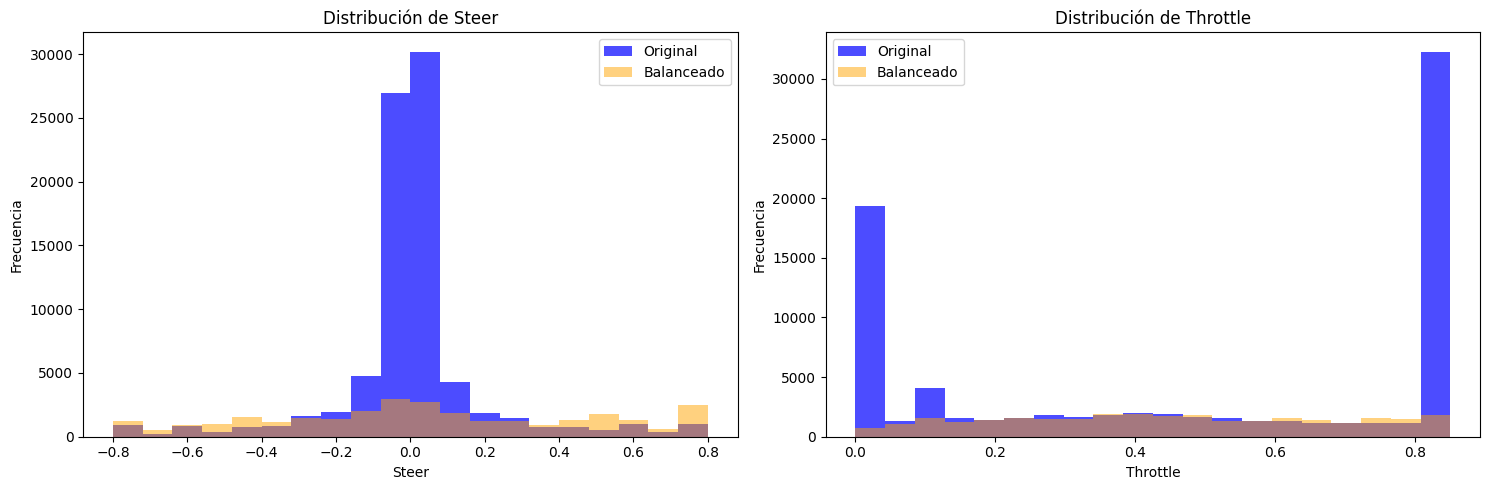

In [43]:
plot_steer_throttle_comparison(df, df_balanced)


In [44]:
len(df_balanced)

29625